Iter 1: Added SV 99, L = 76332.7548, RMSE = 0.1381
Iter 2: Added SV 53, L = 58703.0068, RMSE = 0.1211
Iter 3: Added SV 146, L = 26956.3344, RMSE = 0.0821
Iter 4: Added SV 117, L = 19039.4649, RMSE = 0.0690
Iter 5: Added SV 85, L = 8887.0223, RMSE = 0.0471
Iter 6: Added SV 128, L = 6123.3398, RMSE = 0.0391
Iter 7: Added SV 29, L = 4662.3949, RMSE = 0.0341
Iter 8: Added SV 175, L = 1156.4781, RMSE = 0.0170
Iter 9: Added SV 18, L = 427.7935, RMSE = 0.0103
Iter 10: Added SV 108, L = 309.0332, RMSE = 0.0088


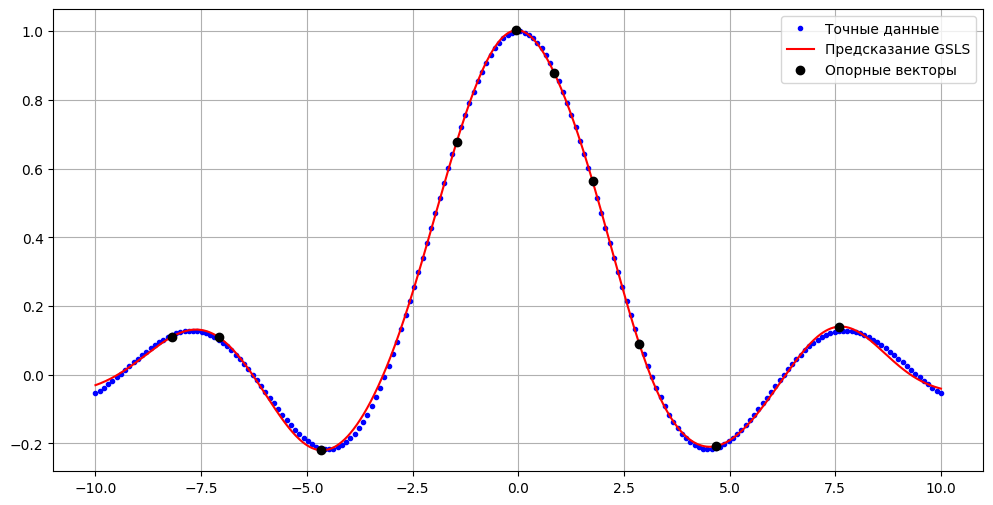

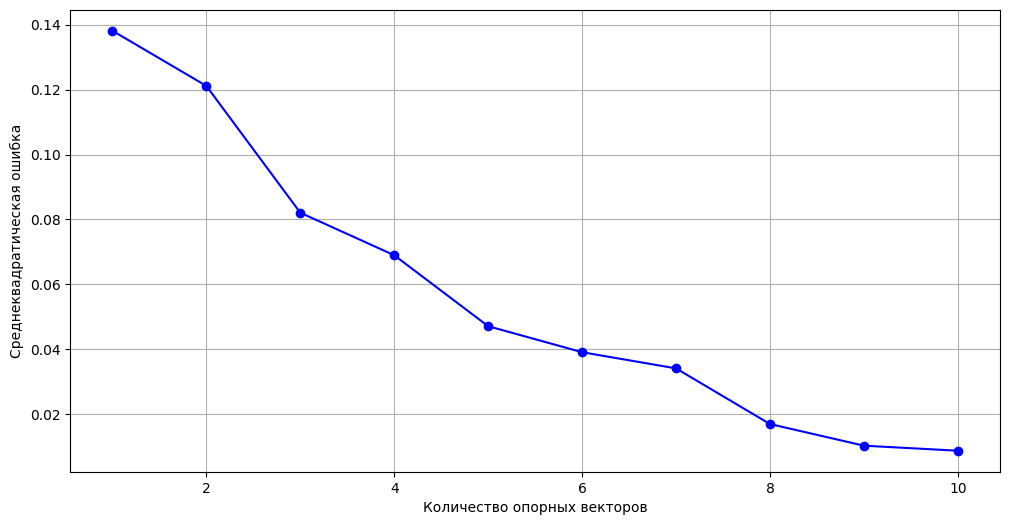

Iter 1: Added SV 100, L = 114547.0693, RMSE = 0.1692
Iter 2: Added SV 52, L = 96027.9721, RMSE = 0.1549
Iter 3: Added SV 145, L = 63895.1891, RMSE = 0.1264
Iter 4: Added SV 82, L = 56474.6987, RMSE = 0.1188
Iter 5: Added SV 114, L = 42337.2009, RMSE = 0.1029
Iter 6: Added SV 171, L = 38732.2559, RMSE = 0.0984
Iter 7: Added SV 27, L = 35361.5995, RMSE = 0.0940
Iter 8: Added SV 83, L = 33537.7778, RMSE = 0.0916
Iter 9: Added SV 127, L = 33142.0884, RMSE = 0.0910
Iter 10: Added SV 172, L = 32827.3820, RMSE = 0.0906


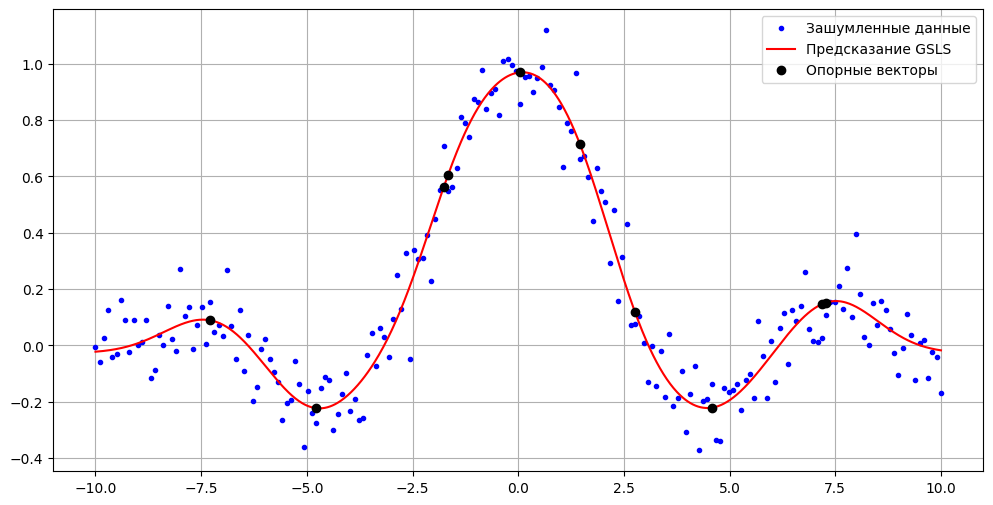

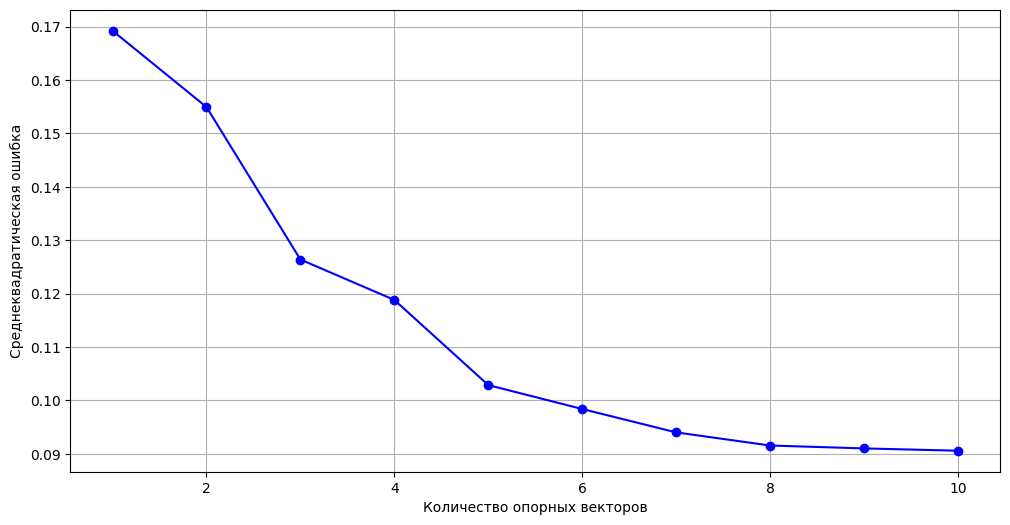

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class GSLS:
    def __init__(self, kernel_type='rbf', kernel_param=1.0, gamma=1.0, max_SV=50, min_delta_L=1e-6):
        self.kernel_type = kernel_type
        self.kernel_param = kernel_param
        self.gamma = gamma
        self.max_SV = max_SV
        self.min_delta_L = min_delta_L
        self.SVs = None
        self.beta = None
        self.bias = 0
        self.K_inv = None
        self.rmse_history = []  # Для хранения истории RMSE

    def kernel(self, x1, x2):
        if self.kernel_type == 'rbf':
            sq_dists = np.sum(x1 ** 2, axis=1).reshape(-1, 1) + np.sum(x2 ** 2, axis=1) - 2 * np.dot(x1, x2.T)
            return np.exp(-sq_dists / (2 * self.kernel_param ** 2))
        elif self.kernel_type == 'linear':
            return np.dot(x1, x2.T)
        else:
            raise ValueError("Unknown kernel type")

    def fit(self, X, y):
        n_samples = X.shape[0]
        flags = np.zeros(n_samples, dtype=bool)
        self.SVs = np.zeros((0, X.shape[1]))
        self.beta = np.zeros(0)
        self.bias = 0
        self.K_inv = None
        self.rmse_history = []  # Сброс истории при новом обучении

        prev_L = np.inf

        for iteration in range(self.max_SV):
            min_L = np.inf
            best_idx = -1
            best_beta = None
            best_bias = 0
            best_K_inv = None

            for t in range(n_samples):
                if not flags[t]:
                    # Временно добавляем кандидата
                    candidate = X[t:t + 1]
                    temp_SVs = np.vstack([self.SVs, candidate]) if self.SVs.size > 0 else candidate

                    # Вычисляем ядерные матрицы
                    K_DD = self.kernel(temp_SVs, temp_SVs)
                    K_DX = self.kernel(temp_SVs, X)

                    # Строим матрицу H
                    l = n_samples
                    Omega = (l / (2 * self.gamma)) * K_DD + K_DX @ K_DX.T
                    Phi = np.sum(K_DX, axis=1)

                    # Формируем систему уравнений
                    if iteration == 0:
                        # Первая итерация - простое решение
                        A = np.array([[Omega.item(), Phi.item()],
                                      [Phi.item(), l]])
                        rhs = np.array([np.dot(K_DX.flatten(), y), np.sum(y)])
                    else:
                        # Последующие итерации
                        A = np.zeros((Omega.shape[0] + 1, Omega.shape[1] + 1))
                        A[:-1, :-1] = Omega
                        A[:-1, -1] = Phi
                        A[-1, :-1] = Phi
                        A[-1, -1] = l
                        rhs = np.concatenate([K_DX @ y, [np.sum(y)]])

                    try:
                        solution = np.linalg.solve(A, rhs)
                    except np.linalg.LinAlgError:
                        solution = np.linalg.lstsq(A, rhs, rcond=None)[0]

                    beta_temp = solution[:-1]
                    bias_temp = solution[-1]

                    # Вычисляем целевую функцию
                    pred = K_DX.T @ beta_temp + bias_temp
                    L = 0.5 * beta_temp.T @ K_DD @ beta_temp + (self.gamma / l) * np.sum((y - pred) ** 2)

                    if L < min_L:
                        min_L = L
                        best_idx = t
                        best_beta = beta_temp
                        best_bias = bias_temp
                        best_K_inv = np.linalg.inv(Omega) if iteration == 0 else None

            # Критерий остановки
            if iteration > 0 and (np.isinf(min_L) or (prev_L - min_L) < self.min_delta_L):
                break

            prev_L = min_L

            if best_idx != -1:
                self.SVs = np.vstack([self.SVs, X[best_idx:best_idx + 1]]) if self.SVs.size > 0 else X[
                                                                                                     best_idx:best_idx + 1]
                self.beta = best_beta
                self.bias = best_bias
                flags[best_idx] = True

                # Вычисляем RMSE и сохраняем в историю
                y_pred = self.predict(X)
                rmse = np.sqrt(np.mean((y - y_pred) ** 2))
                self.rmse_history.append(rmse)

                print(f'Iter {iteration + 1}: Added SV {best_idx}, L = {min_L:.4f}, RMSE = {rmse:.4f}')
            else:
                break

    def predict(self, X):
        if self.SVs is None or len(self.SVs) == 0:
            raise ValueError("Model not trained yet")
        K = self.kernel(self.SVs, X)
        return K.T @ self.beta + self.bias


def run_experiments():
    def sinc(x):
        return np.where(x == 0, 1.0, np.sin(x) / x)

    np.random.seed(42)
    n_samples = 200
    x = np.linspace(-10, 10, n_samples).reshape(-1, 1)
    y = sinc(x).ravel()

    # 1. Точные данные
    model = GSLS(kernel_type='rbf', kernel_param=1.06, gamma=4000000, max_SV=10)
    model.fit(x, y)

    x_test = np.linspace(-10, 10, 1000).reshape(-1, 1)
    y_pred = model.predict(x_test)

    plt.figure(figsize=(12, 6))
    plt.plot(x, y, 'b.', label='Точные данные')
    plt.plot(x_test, y_pred, 'r-', label='Предсказание GSLS')
    plt.plot(model.SVs, model.predict(model.SVs), 'ko', label='Опорные векторы')
    plt.legend()
    plt.grid()
    plt.show()

    # График RMSE от количества опорных векторов (точные данные)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(model.rmse_history) + 1), model.rmse_history, 'bo-')
    plt.xlabel('Количество опорных векторов')
    plt.ylabel('Среднеквадратическая ошибка')
    plt.grid()
    plt.show()

    # 2. Зашумленные данные
    noise_std = 0.1
    y_noisy = y + noise_std * np.random.randn(n_samples)

    model_noisy = GSLS(kernel_type='rbf', kernel_param=1.06, gamma=4000000, max_SV=10)
    model_noisy.fit(x, y_noisy)
    y_noisy_pred = model_noisy.predict(x_test)

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_noisy, 'b.', label='Зашумленные данные')
    plt.plot(x_test, y_noisy_pred, 'r-', label='Предсказание GSLS')
    plt.plot(model_noisy.SVs, model_noisy.predict(model_noisy.SVs), 'ko', label='Опорные векторы')
    plt.legend()
    plt.grid()
    plt.show()

    # График RMSE от количества опорных векторов (зашумленные данные)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(model_noisy.rmse_history) + 1), model_noisy.rmse_history, 'bo-')
    plt.xlabel('Количество опорных векторов')
    plt.ylabel('Среднеквадратическая ошибка')
    plt.grid()
    plt.show()


if __name__ == "__main__":
    run_experiments()